# Using information theory to evaluate features

The mutual information (MI) between a feature and the outcome is a measure of the mutual dependence between the two variables. It extends the notion of correlation to nonlinear relationships. More specifically, it quantifies the information obtained about one random variable through the other random variable.

The concept of MI is closely related to the fundamental notion of entropy of a random variable. Entropy quantifies the amount of information contained in a random variable. Formally, the mutual information—I(X, Y)—of two random variables, X and Y, is defined as the following:

The sklearn function implements feature_selection.mutual_info_regression that computes the mutual information between all features and a continuous outcome to select the features that are most likely to contain predictive information. There is also a classification version (see the documentation for more details). 

This notebook contains an application to the financial data we created in Chapter 4, Alpha Factor Research.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import mutual_info_classif

In [3]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

## Get Data

We use the data produced in [Chapter 4](../../04_alpha_factor_research/00_data/feature_engineering.ipynb).


In [4]:
with pd.HDFStore('../data/assets.h5') as store:
    data = store['engineered_features']

In [5]:
data

return_1m  return_2m  return_3m  return_6m  return_9m  \
ticker date                                                                
A      2001-01-31  -0.003653   0.022360   0.056104   0.049811  -0.052500   
       2001-02-28  -0.329564  -0.189115  -0.116435  -0.084141  -0.076425   
       2001-03-31  -0.146389  -0.249443  -0.175116  -0.074628  -0.092690   
       2001-04-30   0.269444   0.040966  -0.105747  -0.028185  -0.004837   
       2001-05-31  -0.140220   0.044721  -0.023317  -0.071042  -0.064299   
...                      ...        ...        ...        ...        ...   
ZUMZ   2017-10-31  -0.024862   0.190660   0.115956  -0.002805  -0.014066   
       2017-11-30   0.235127   0.097461   0.205302   0.073430   0.007402   
       2017-12-31  -0.044725   0.086226   0.047857   0.090987   0.014465   
       2018-01-31  -0.003601  -0.024380   0.055418   0.085265   0.016237   
       2018-02-28  -0.050602  -0.027386  -0.033200   0.079484   0.036640   

                   return_12m    Mkt-RF       SMB       HML       RMW  ...  \
ticker date                                                            ...   
A      2001-01-31   -0.015988  1.270597  0.554078 -0.673132 -1.309609  ...   
       2001-02-28   -0.084537  1.270597  0.554078 -0.673132 -1.309609  ...   
       2001-03-31   -0.096606  1.270597  0.554078 -0.673132 -1.309609  ...   
       2001-04-30   -0.066102  1.270597  0.554078 -0.673132 -1.309609  ...   
       2001-05-31   -0.063425  1.270597  0.554078 -0.673132 -1.309609  ...   
...                       ...       ...       ...       ...       ...  ...   
ZUMZ   2017-10-31   -0.019115  0.092819  0.267524  1.133606  2.575263  ...   
       2017-11-30   -0.010687 -0.766268  0.954926  1.406923  2.898318  ...   
       2017-12-31   -0.003996 -0.772464  1.307170  1.383565  3.440287  ...   
       2018-01-31    0.002864 -0.967332  1.658391  1.602919  3.652837  ...   
       2018-02-28   -0.002905  0.077844  1.176237  1.394623  2.987292  ...   

                   return_1m_t-5  return_1m_t-6  target_1m  target_2m  \
ticker date                                                             
A      2001-01-31            NaN            NaN  -0.329564  -0.249443   
       2001-02-28            NaN            NaN  -0.146389   0.040966   
       2001-03-31            NaN            NaN   0.269444   0.044721   
       2001-04-30            NaN            NaN  -0.140220  -0.087246   
       2001-05-31            NaN            NaN  -0.031008  -0.076414   
...                          ...            ...        ...        ...   
ZUMZ   2017-10-31      -0.206128      -0.019126   0.235127   0.086226   
       2017-11-30      -0.133333      -0.206128  -0.044725  -0.024380   
       2017-12-31       0.028340      -0.133333  -0.003601  -0.027386   
       2018-01-31      -0.019685       0.028340  -0.050602   0.066466   
       2018-02-28       0.430943      -0.019685   0.197970        NaN   

                   target_3m  target_6m  target_12m  age  msize  \
ticker date                                                       
A      2001-01-31  -0.105747  -0.101978   -0.047686    2   10.0   
       2001-02-28  -0.023317  -0.049781   -0.011986    2    9.0   
       2001-03-31   0.018842  -0.072607    0.010805    2    9.0   
       2001-04-30  -0.098192  -0.089198   -0.021512    2    9.0   
       2001-05-31  -0.075527  -0.033904   -0.019843    2    9.0   
...                      ...        ...         ...  ...    ...   
ZUMZ   2017-10-31   0.055418        NaN         NaN    3    2.0   
       2017-11-30  -0.033200        NaN         NaN    3    2.0   
       2017-12-31   0.042579        NaN         NaN    3    2.0   
       2018-01-31        NaN        NaN         NaN    3    2.0   
       2018-02-28        NaN        NaN         NaN    3    2.0   

                              sector  
ticker date                           
A      2001-01-31      Capital Goods  
       2001-02-28      Capital Goods  
       2001-03-31      Capital Goods 

## Create Dummy variables

In [12]:
dummy_data = pd.get_dummies(data,
                            columns=['year','month', 'msize', 'age',  'sector'],
                            prefix=['year','month', 'msize', 'age', ''],
                            prefix_sep=['_', '_', '_', '_', ''])
dummy_data = dummy_data.rename(columns={c:c.replace('.0', '') for c in dummy_data.columns})
dummy_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 358914 entries, ('A', Timestamp('2001-01-31 00:00:00')) to ('ZUMZ', Timestamp('2018-02-28 00:00:00'))
Data columns (total 88 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   return_1m              358914 non-null  float64
 1   return_2m              358914 non-null  float64
 2   return_3m              358914 non-null  float64
 3   return_6m              358914 non-null  float64
 4   return_9m              358914 non-null  float64
 5   return_12m             358914 non-null  float64
 6   Mkt-RF                 358914 non-null  float64
 7   SMB                    358914 non-null  float64
 8   HML                    358914 non-null  float64
 9   RMW                    358914 non-null  float64
 10  CMA                    358914 non-null  float64
 11  momentum_2             358914 non-null  float64
 12  momentum_3             358914 non-null  float64
 13  momentum_6     

## Mutual Information

### Original Data

In [19]:
target_labels = [f'target_{i}m' for i in [1,2,3,6,12]]
targets = data.dropna().loc[:, target_labels]

features = data.dropna().drop(target_labels, axis=1)
features.sector = pd.factorize(features.sector)[0]

cat_cols = ['year', 'month', 'msize', 'age', 'sector']
discrete_features = [features.columns.get_loc(c) for c in cat_cols]

In [20]:
mutual_info = pd.DataFrame()
for label in target_labels:
    mi = mutual_info_classif(X=features, 
                             y=(targets[label]> 0).astype(int),
                             discrete_features=discrete_features,
                             random_state=42
                            )
    mutual_info[label] = pd.Series(mi, index=features.columns) # see if each feature is useful for predicting each target, 1 for > 0 , 0 for <= 0 returns

In [21]:
mutual_info

,target_1m,target_2m,target_3m,target_6m,target_12m
return_1m,0.000000,0.000910,0.000280,0.002505,0.003325
return_2m,0.000682,0.001372,0.003034,0.001245,0.003690
return_3m,0.000308,0.000943,0.001647,0.001355,0.002691
return_6m,0.001589,0.000924,0.000388,0.000616,0.002943
return_9m,0.000383,0.000966,0.000000,0.003653,0.002528
return_12m,0.000108,0.001262,0.002635,0.001584,0.001943
Mkt-RF,0.000000,0.002412,0.004950,0.008793,0.017664
SMB,0.000904,0.001521,0.003623,0.008896,0.017231
HML,0.000316,0.004843,0.006892,0.009346,0.019163
RMW,0.002897,0.001901,0.004458,0.009299,0.019559


In [22]:
mutual_info.sum(axis = 0)

target_1m     0.033629
target_2m     0.059443
target_3m     0.090229
target_6m     0.132718
target_12m    0.198728
dtype: float64

### Normalized MI Heatmap

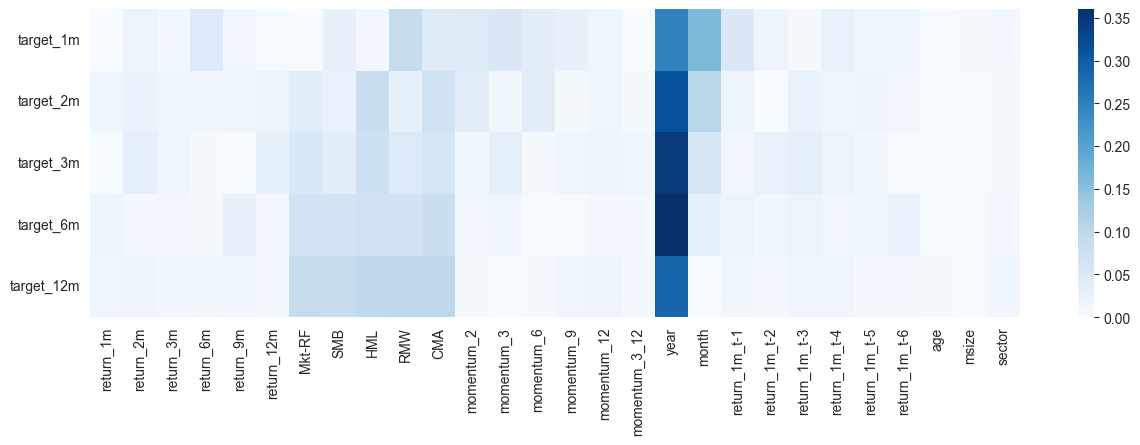

In [23]:
fig, ax= plt.subplots(figsize=(15, 4))
sns.heatmap(mutual_info.div(mutual_info.sum()).T, ax=ax, cmap='Blues');

### Dummy Data

In [25]:
dummy_data.columns

Index(['return_1m', 'return_2m', 'return_3m', 'return_6m', 'return_9m',
       'return_12m', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'momentum_2',
       'momentum_3', 'momentum_6', 'momentum_9', 'momentum_12',
       'momentum_3_12', 'return_1m_t-1', 'return_1m_t-2', 'return_1m_t-3',
       'return_1m_t-4', 'return_1m_t-5', 'return_1m_t-6', 'target_1m',
       'target_2m', 'target_3m', 'target_6m', 'target_12m', 'year_2001',
       'year_2002', 'year_2003', 'year_2004', 'year_2005', 'year_2006',
       'year_2007', 'year_2008', 'year_2009', 'year_2010', 'year_2011',
       'year_2012', 'year_2013', 'year_2014', 'year_2015', 'year_2016',
       'year_2017', 'year_2018', 'month_1', 'month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
       'month_11', 'month_12', 'msize_-1', 'msize_1', 'msize_2', 'msize_3',
       'msize_4', 'msize_5', 'msize_6', 'msize_7', 'msize_8', 'msize_9',
       'msize_10', 'age_0', 'age_1', 'age_2', 'age_3', '

In [26]:
features.columns

Index(['return_1m', 'return_2m', 'return_3m', 'return_6m', 'return_9m',
       'return_12m', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'momentum_2',
       'momentum_3', 'momentum_6', 'momentum_9', 'momentum_12',
       'momentum_3_12', 'year', 'month', 'return_1m_t-1', 'return_1m_t-2',
       'return_1m_t-3', 'return_1m_t-4', 'return_1m_t-5', 'return_1m_t-6',
       'age', 'msize', 'sector'],
      dtype='object')

In [27]:
dummy_data.dropna().drop(target_labels, axis=1).columns

Index(['return_1m', 'return_2m', 'return_3m', 'return_6m', 'return_9m',
       'return_12m', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'momentum_2',
       'momentum_3', 'momentum_6', 'momentum_9', 'momentum_12',
       'momentum_3_12', 'return_1m_t-1', 'return_1m_t-2', 'return_1m_t-3',
       'return_1m_t-4', 'return_1m_t-5', 'return_1m_t-6', 'year_2001',
       'year_2002', 'year_2003', 'year_2004', 'year_2005', 'year_2006',
       'year_2007', 'year_2008', 'year_2009', 'year_2010', 'year_2011',
       'year_2012', 'year_2013', 'year_2014', 'year_2015', 'year_2016',
       'year_2017', 'year_2018', 'month_1', 'month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
       'month_11', 'month_12', 'msize_-1', 'msize_1', 'msize_2', 'msize_3',
       'msize_4', 'msize_5', 'msize_6', 'msize_7', 'msize_8', 'msize_9',
       'msize_10', 'age_0', 'age_1', 'age_2', 'age_3', 'age_4', 'age_5',
       'Basic Industries', 'Capital Goods', 'Consumer Du

In [28]:
target_labels = [f'target_{i}m' for i in [1, 2, 3, 6, 12]]
dummy_targets = dummy_data.dropna().loc[:, target_labels] # get target columns

dummy_features = dummy_data.dropna().drop(target_labels, axis=1) # get dummy feature columns, like year_2002, year_2003 etc.
cat_cols = [c for c in dummy_features.columns if c not in features.columns] # get categorical columns, which we processed before with get_dummies
discrete_features = [dummy_features.columns.get_loc(c) for c in cat_cols]

In [30]:
cat_cols

['year_2001',
 'year_2002',
 'year_2003',
 'year_2004',
 'year_2005',
 'year_2006',
 'year_2007',
 'year_2008',
 'year_2009',
 'year_2010',
 'year_2011',
 'year_2012',
 'year_2013',
 'year_2014',
 'year_2015',
 'year_2016',
 'year_2017',
 'year_2018',
 'month_1',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'month_10',
 'month_11',
 'month_12',
 'msize_-1',
 'msize_1',
 'msize_2',
 'msize_3',
 'msize_4',
 'msize_5',
 'msize_6',
 'msize_7',
 'msize_8',
 'msize_9',
 'msize_10',
 'age_0',
 'age_1',
 'age_2',
 'age_3',
 'age_4',
 'age_5',
 'Basic Industries',
 'Capital Goods',
 'Consumer Durables',
 'Consumer Non-Durables',
 'Consumer Services',
 'Energy',
 'Finance',
 'Health Care',
 'Miscellaneous',
 'Public Utilities',
 'Technology',
 'Transportation',
 'Unknown']

In [29]:
discrete_features

[23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82]

In [31]:
mutual_info_dummies = pd.DataFrame()
for label in target_labels:
    mi = mutual_info_classif(X=dummy_features, 
                             y=(dummy_targets[label]> 0).astype(int),
                             discrete_features=discrete_features,
                             random_state=42
                            )    
    mutual_info_dummies[label] = pd.Series(mi, index=dummy_features.columns)

In [32]:
mutual_info_dummies.sum()

target_1m     0.034769
target_2m     0.061374
target_3m     0.092935
target_6m     0.136692
target_12m    0.203462
dtype: float64

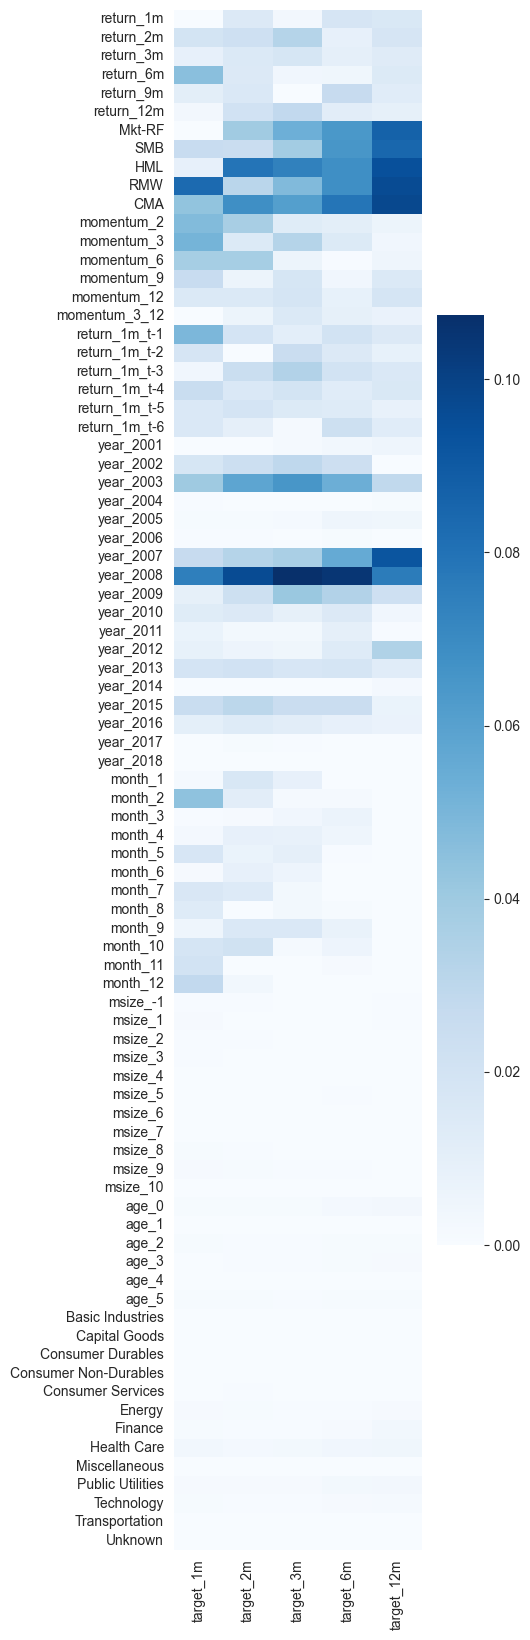

In [33]:
fig, ax= plt.subplots(figsize=(4, 20))
sns.heatmap(mutual_info_dummies.div(mutual_info_dummies.sum()), ax=ax, cmap='Blues');